In [1]:
!ls /kaggle/input/drowsiness-dataset

drowsiness-dataset  prediction-images


In [2]:
base_path = '/kaggle/input/drowsiness-dataset/'

In [3]:
import requests
from IPython.display import Image
import numpy as np
import pandas as pd 
import os
import cv2
!pip install opendatasets 
!pip install pandas


In [ ]:
def face_for_yawn(direc=f"{base_path}/drowsiness-dataset/drowsiness-dataset/train", face_cas_path=f"{base_path}/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []  
    IMG_SIZE = 145  
    categories = ["yawn", "no_yawn"]  s
    for category in categories:
        path_link = os.path.join(direc, category)  
        class_num1 = categories.index(category)  
        print(class_num1)  
        for image in os.listdir(path_link):  
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)  
            face_cascade = cv2.CascadeClassifier(face_cas_path)  
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)  
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)  
                roi_color = img[y:y+h, x:x+w]  
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))  
                yaw_no.append([resized_array, class_num1])  
    return yaw_no  

yawn_no_yawn = face_for_yawn()  

0
1


In [ ]:
def get_data(dir_path=f"{base_path}/drowsiness-dataset/drowsiness-dataset/train/", face_cas=f"{base_path}/prediction-images/haarcascade_frontalface_default.xml", eye_cas=f"{base_path}/prediction-images/haarcascade.xml"):

    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num += 2
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [7]:
data_train = get_data()

In [8]:
import numpy as np

def append_data():
    yaw_no = face_for_yawn()
    
    data = get_data()
    
    yaw_no.extend(data)
    
    final_data = []

    for img, label in yaw_no:
        final_data.append([np.array(img), np.array(label)])  # make sure both img and label are numpy arrays

    
    return np.array(final_data, dtype=object)
new_data = append_data()

0
1


In [ ]:

X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(int(label))  # Convert label to int

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [10]:
y = np.array(y)

In [11]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [12]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import
import tensorflow as tf

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model = Sequential()
model.add(Conv2D(512, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,873,924 (18.59 MB)

 Trainable params: 4,873,924 (18.59 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(train_generator, epochs=30, validation_data=test_generator, shuffle=True, validation_steps=30)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731745192.834705     121 service.cc:145] XLA service 0x7cbafc01abe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731745192.834775     121 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731745192.834780     121 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-16 08:20:11.506546: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=2,k3=0} for conv (f32[32,512,71,71]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,69,69]{3,2,1,0}, f32[512,512,3,3]

27/43 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 0.3536 - loss: 1.3539

I0000 00:00:1731745243.824980     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 24 bytes spill stores, 24 bytes spill loads



43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 584ms/step - accuracy: 0.3629 - loss: 1.3414 - val_accuracy: 0.3720 - val_loss: 1.2679
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step - accuracy: 0.4732 - loss: 1.1188 - val_accuracy: 0.6125 - val_loss: 1.0217
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 298ms/step - accuracy: 0.7358 - loss: 0.6158 - val_accuracy: 0.8270 - val_loss: 0.3335
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 300ms/step - accuracy: 0.8382 - loss: 0.3706 - val_accuracy: 0.8131 - val_loss: 0.3103
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.8579 - loss: 0.3227 - val_accuracy: 0.8443 - val_loss: 0.3993
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.8527 - loss: 0.3434 - val_accuracy: 0.9204 - val_loss: 0.1798
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 304ms/step - accuracy: 0.8773 - loss: 0.2833 - val_accuracy: 0.9152 - val_loss: 0.2147
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.9036 - loss: 0.2414 - val_accuracy: 0.9343 - val_loss: 0.1654
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step - accuracy: 0.9076 - loss: 0.2230 - val_accuracy: 0.942

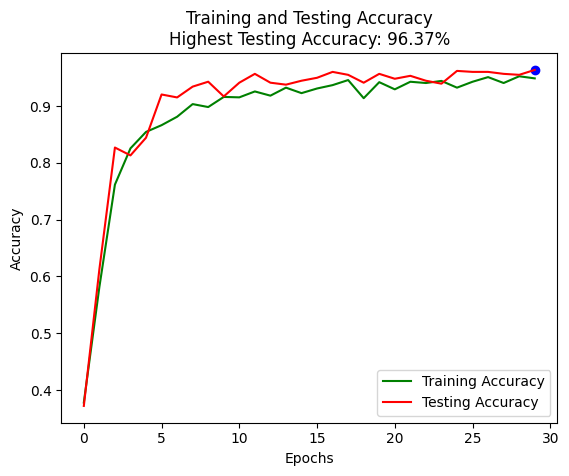

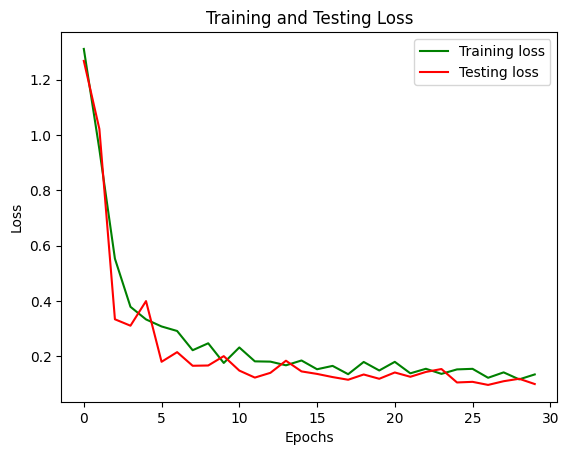

In [ ]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

max_val_acc = max(val_accuracy)
max_val_acc_index = val_accuracy.index(max_val_acc)

min_val_acc = min(val_accuracy)
max_accuracy = max(accuracy)
min_loss =  min(loss)
min_val_loss = min(val_loss)

plt.plot(max_val_acc_index, max_val_acc, marker='o', color='blue')

plt.plot(epochs, accuracy, "g", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Testing Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy\nHighest Testing Accuracy: {:.2f}%".format(max_val_acc*100))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Testing loss")
plt.legend()
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
from tabulate import tabulate
table = [["Maximum Testing accuracy:", f"\033[1;32m{max_val_acc:.4f}\033[0m"],
         ["Maximum Training accuracy:", f"\033[1;32m{max_accuracy:.4f}\033[0m"],
         ["Minimum Training Loss:", f"\033[1;31m{min_loss:.4f}\033[0m"],
         ["Minimum Testing Loss:", f"\033[1;31m{min_val_loss:.4f}\033[0m"]]
print(tabulate(table, headers=["Metric", "Value"], tablefmt="fancy_grid"))

╒════════════════════════════╤═════════╕
│ Metric                     │   Value │
╞════════════════════════════╪═════════╡
│ Maximum Testing accuracy:  │  0.9637 │
├────────────────────────────┼─────────┤
│ Maximum Training accuracy: │  0.9525 │
├────────────────────────────┼─────────┤
│ Minimum Training Loss:     │  0.1162 │
├────────────────────────────┼─────────┤
│ Minimum Testing Loss:      │  0.0961 │
╘════════════════════════════╧═════════╛


In [ ]:
preds = model.predict(X_test)
predicted_classes = preds.argmax(axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


In [22]:
predicted_classes

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 3, 3,
       2, 1, 0, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 3, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       1, 1, 2, 1, 1, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 2, 2, 0, 3, 3,
       1, 3, 1, 2, 3, 3, 0, 1, 2, 2, 0, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3,
       3, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 0, 3, 3, 3, 1, 2, 0, 1, 3, 2, 3, 3, 2, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 2, 3, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 1, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 0, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

In [23]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming you already have the predicted classes and true labels
predicted_classes = preds.argmax(axis=1)
true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate specificity for each class and store them
specificity = {}
supports = np.bincount(true_classes)  # Number of true instances for each class
for i in range(cm.shape[0]):
    # True Negatives (TN) for class i
    TN = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
    # False Positives (FP) for class i
    FP = np.sum(cm[:, i]) - cm[i, i]
    specificity[i] = TN / (TN + FP)

# Calculate macro average specificity
macro_avg_specificity = np.mean(list(specificity.values()))

# Calculate weighted average specificity
weighted_avg_specificity = np.sum([specificity[i] * supports[i] for i in range(len(specificity))]) / np.sum(supports)

# Print the classification report
labels_new = ["yawn", "no_yawn", "Closed", "Open"]  # Update with your class labels
print(classification_report(true_classes, predicted_classes, target_names=labels_new))

# Print specificity for each class
print("\nSpecificity for each class:")
for i, label in enumerate(labels_new):
    print(f"{label}: {specificity[i]:.4f}")

# Print macro and weighted average specificity
print(f"\nMacro Average Specificity: {macro_avg_specificity:.4f}")
print(f"Weighted Average Specificity: {weighted_avg_specificity:.4f}")


              precision    recall  f1-score   support

        yawn       0.88      0.84      0.86        63
     no_yawn       0.87      0.97      0.92        74
      Closed       0.98      0.93      0.95       215
        Open       0.96      0.97      0.96       226

    accuracy                           0.94       578
   macro avg       0.92      0.93      0.92       578
weighted avg       0.94      0.94      0.94       578


Specificity for each class:
yawn: 0.9864
no_yawn: 0.9782
Closed: 0.9862
Open: 0.9716

Macro Average Specificity: 0.9806
Weighted Average Specificity: 0.9795


In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_test and predicted_classes are your true and predicted labels, respectively
# labels_new is a list of class names
cm = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes)

# Print the confusion matrix
print(cm)

[[ 53  10   0   0]
 [  2  72   0   0]
 [  4   0 201  10]
 [  1   1   5 219]]


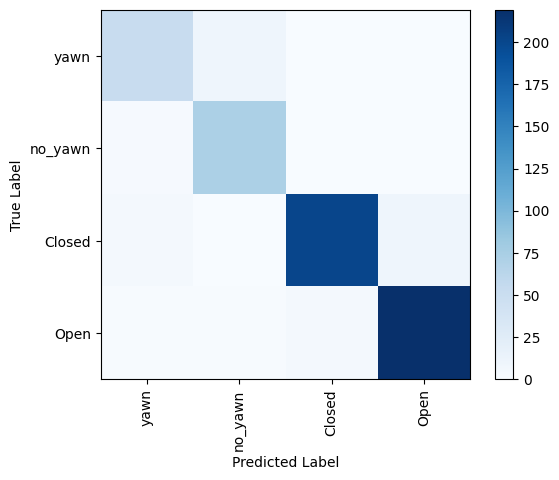

In [26]:
import matplotlib.pyplot as plt

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(labels_new))
plt.xticks(tick_marks, labels_new, rotation=90)
plt.yticks(tick_marks, labels_new)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()